In [ ]:
# mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

# Path to the folder containing the MRI files
folder_path = "/content/drive/MyDrive/MRI/multicoil_test_full"

file_sizes = {}
duplicates = []

for file_name in os.listdir(folder_path):
    file_path = os.path.join(folder_path, file_name)
    if os.path.isfile(file_path):
        file_size = os.path.getsize(file_path)
        if file_size in file_sizes:
            duplicates.append((file_sizes[file_size], file_name))
        else:
            file_sizes[file_size] = file_name


if duplicates:
    print("Duplicate files detected (same sizes):")
    for original, duplicate in duplicates:
        print(f"{original} and {duplicate} have the same size.")
else:
    print("No duplicate files with the same sizes found.")


Duplicate files detected (same sizes):
file_brain_AXT1_202_2020012.h5 and file_brain_AXT1POST_205_2050123.h5 have the same size.
file_brain_AXT1POST_210_6001714.h5 and file_brain_AXT1POST_210_6001565.h5 have the same size.
file_brain_AXT1PRE_203_6000758.h5 and file_brain_AXT1PRE_203_6000891.h5 have the same size.
file_brain_AXT2_200_2000271.h5 and file_brain_AXT2_200_2000341.h5 have the same size.
file_brain_AXT1POST_207_2070506.h5 and file_brain_AXT1POST_207_2070502.h5 have the same size.
file_brain_AXT1POST_210_6001714.h5 and file_brain_AXT1PRE_210_6001861.h5 have the same size.
file_brain_AXT2_200_2000271.h5 and file_brain_AXT2_200_2000534.h5 have the same size.
file_brain_AXT1POST_210_6001714.h5 and file_brain_AXT1PRE_210_6001791.h5 have the same size.
file_brain_AXT1POST_207_2070506.h5 and file_brain_AXT1POST_207_2070682.h5 have the same size.
file_brain_AXT1POST_207_2070506.h5 and file_brain_AXT1POST_207_2070548.h5 have the same size.
file_brain_AXT1PRE_203_6000758.h5 and file_br

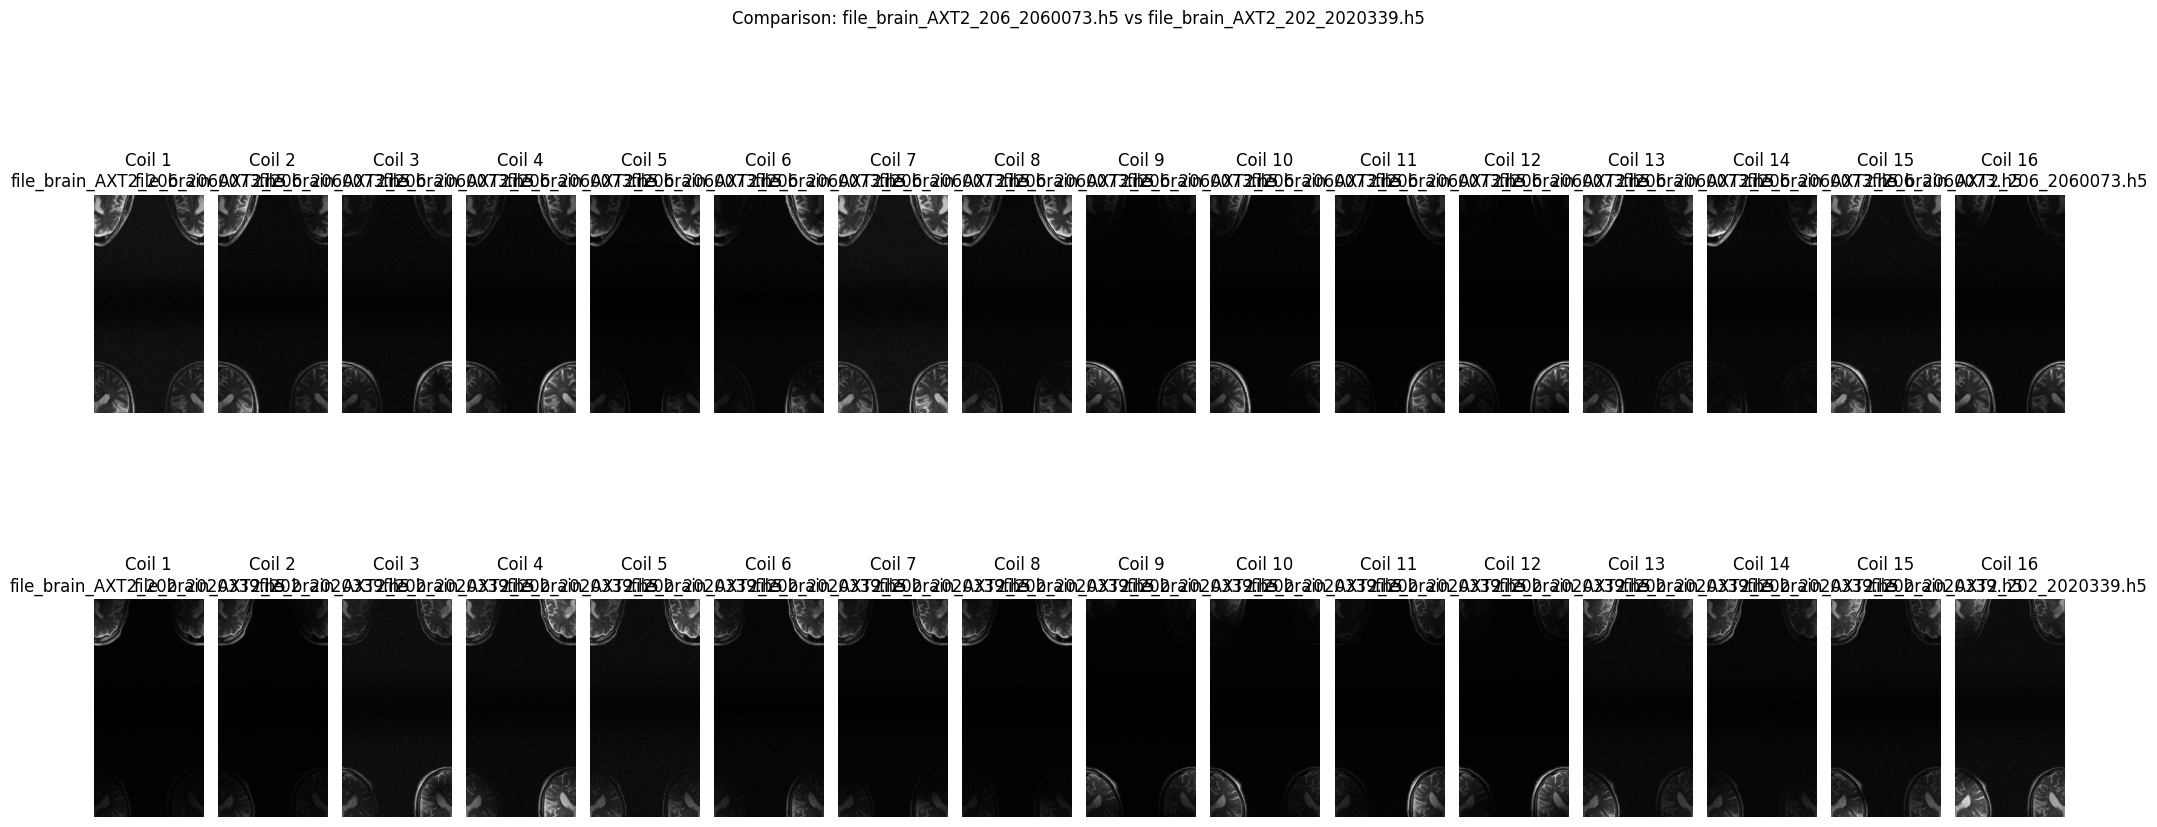

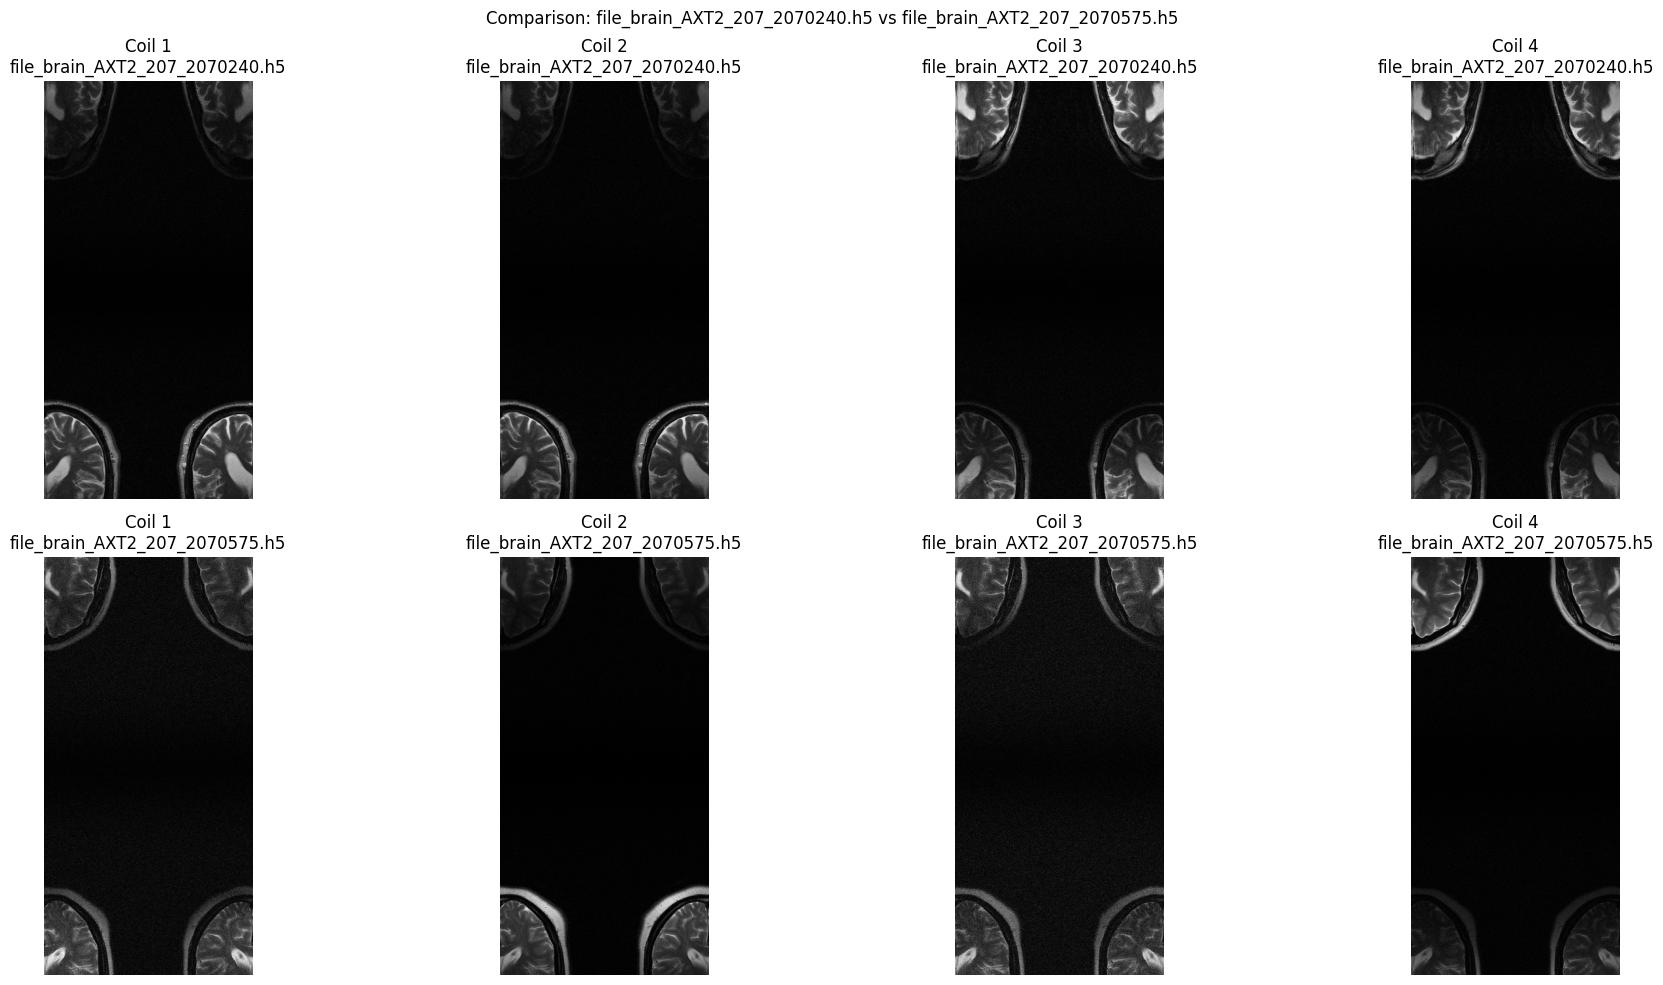

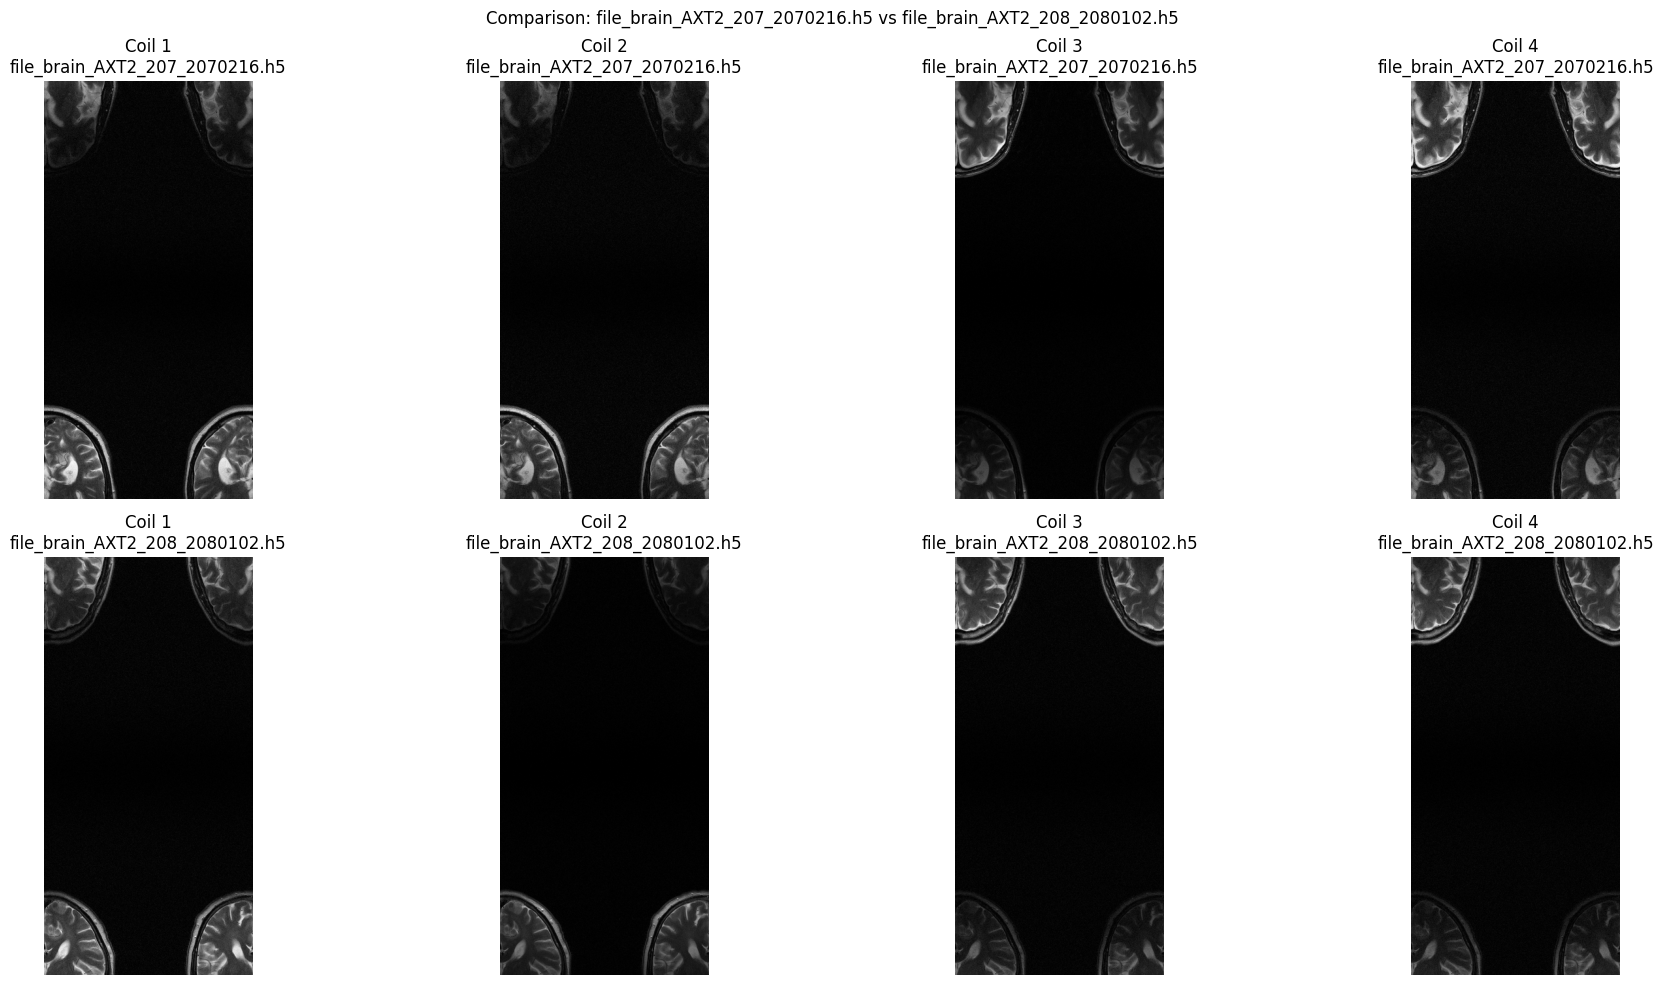

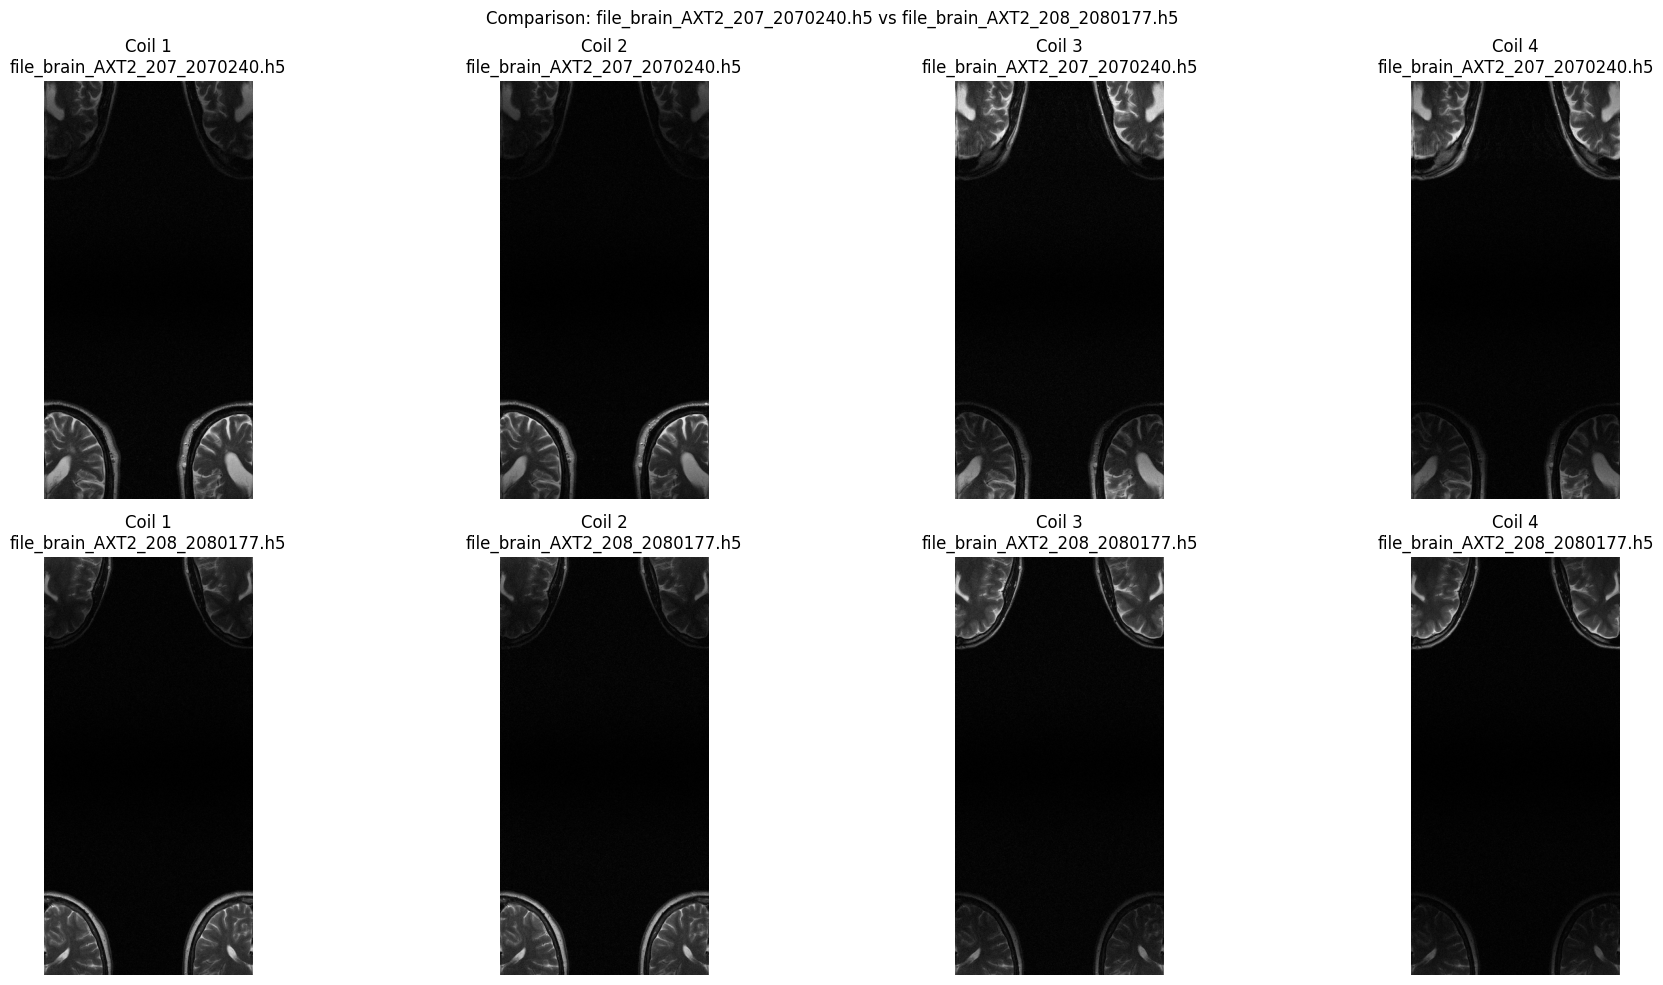

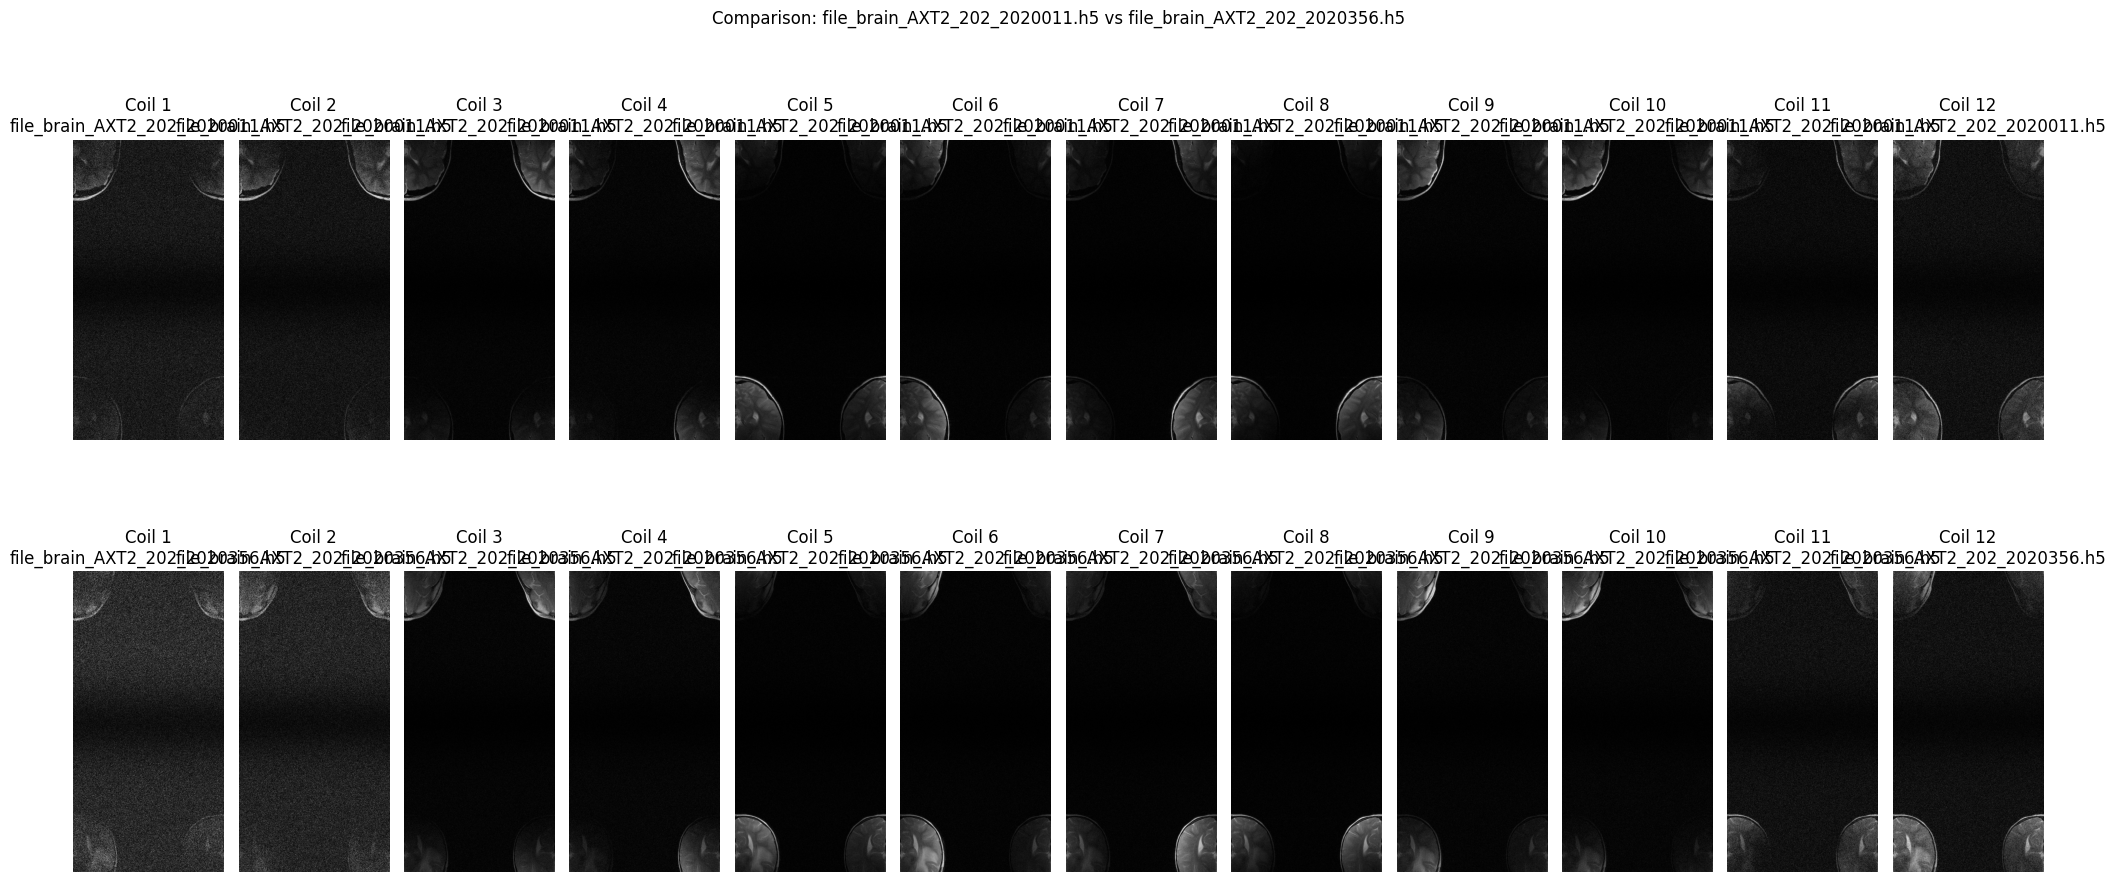

In [ ]:
## doesnt work properly because it doesnt use Inverse fft from fastmri
# checking if the files are same by plotting

import h5py
import numpy as np
import matplotlib.pyplot as plt

folder_path = "/content/drive/MyDrive/MRI/multicoil_test_full"

# List of file pairs to compare
file_pairs = [
    ("file_brain_AXT2_206_2060073.h5", "file_brain_AXT2_202_2020339.h5"),
    ("file_brain_AXT2_207_2070240.h5", "file_brain_AXT2_207_2070575.h5"),
    ("file_brain_AXT2_207_2070216.h5", "file_brain_AXT2_208_2080102.h5"),
    ("file_brain_AXT2_207_2070240.h5", "file_brain_AXT2_208_2080177.h5"),
    ("file_brain_AXT2_202_2020011.h5", "file_brain_AXT2_202_2020356.h5"),
]

def kspace_to_image(kspace_data):
    """Converts k-space data to an image using inverse FFT."""
    image = np.abs(np.fft.ifft2(np.fft.ifftshift(kspace_data)))
    image = (image - np.min(image)) / (np.max(image) - np.min(image)) * 255.0
    return image.astype(np.uint8)

for pair in file_pairs:
    file1_path = f"{folder_path}/{pair[0]}"
    file2_path = f"{folder_path}/{pair[1]}"

    with h5py.File(file1_path, "r") as file1, h5py.File(file2_path, "r") as file2:
        kspace1 = file1["kspace"][:]
        kspace2 = file2["kspace"][:]

        # Generate images from k-space (all coils for the first slice)
        images1 = [kspace_to_image(kspace1[0, coil_idx]) for coil_idx in range(kspace1.shape[1])]
        images2 = [kspace_to_image(kspace2[0, coil_idx]) for coil_idx in range(kspace2.shape[1])]

    fig, axes = plt.subplots(2, len(images1), figsize=(20, 10))

    for idx, (img1, img2) in enumerate(zip(images1, images2)):
        axes[0, idx].imshow(img1, cmap="gray")
        axes[0, idx].axis("off")
        axes[0, idx].set_title(f"Coil {idx + 1}\n{pair[0]}")

        axes[1, idx].imshow(img2, cmap="gray")
        axes[1, idx].axis("off")
        axes[1, idx].set_title(f"Coil {idx + 1}\n{pair[1]}")

    plt.suptitle(f"Comparison: {pair[0]} vs {pair[1]}")
    plt.tight_layout()
    plt.show()


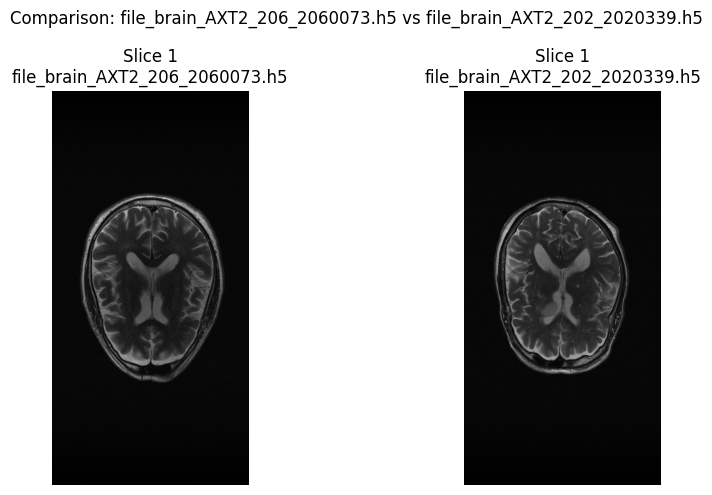

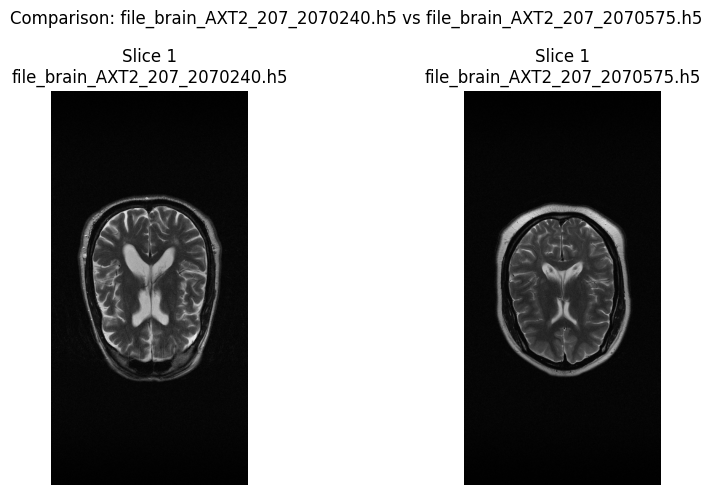

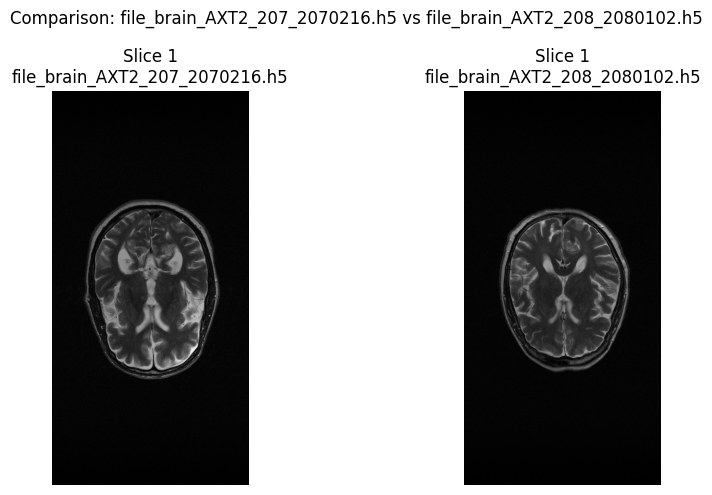

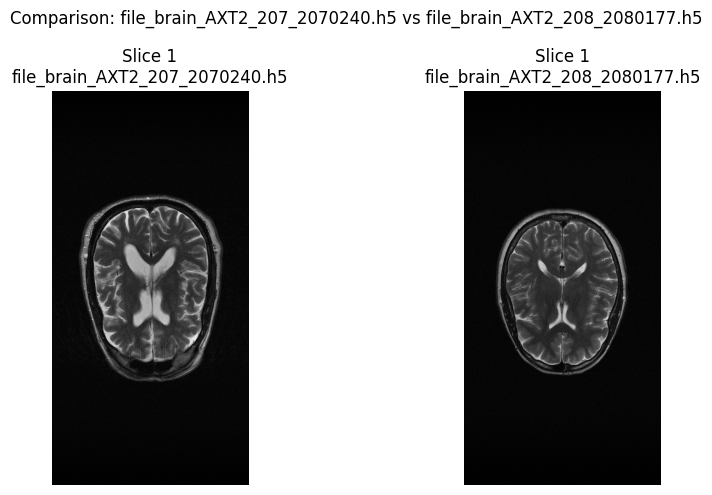

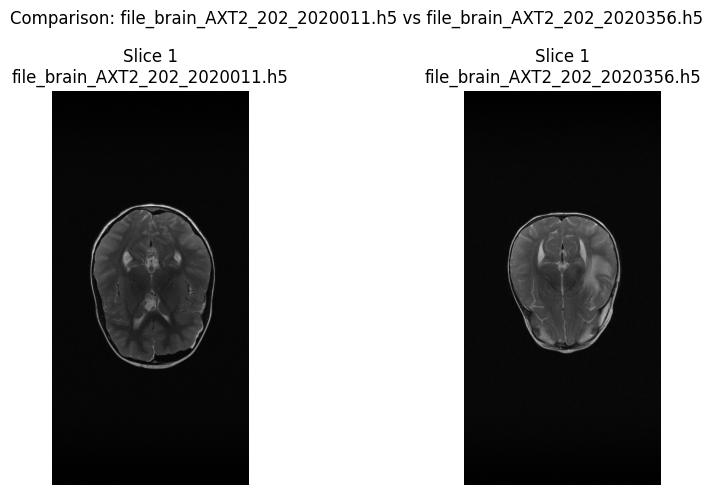

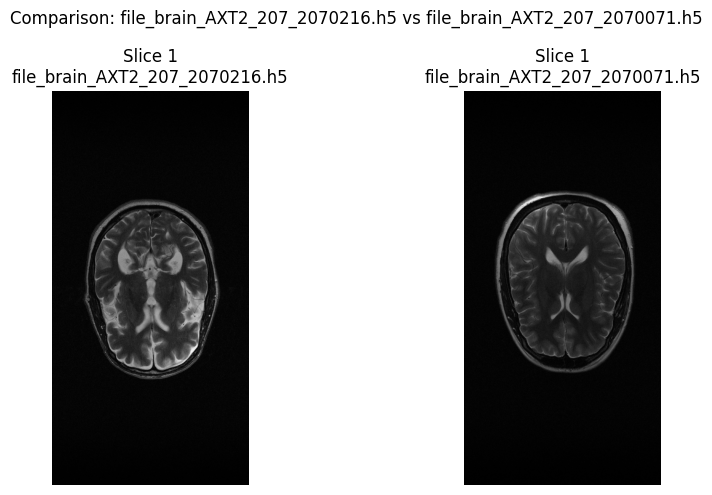

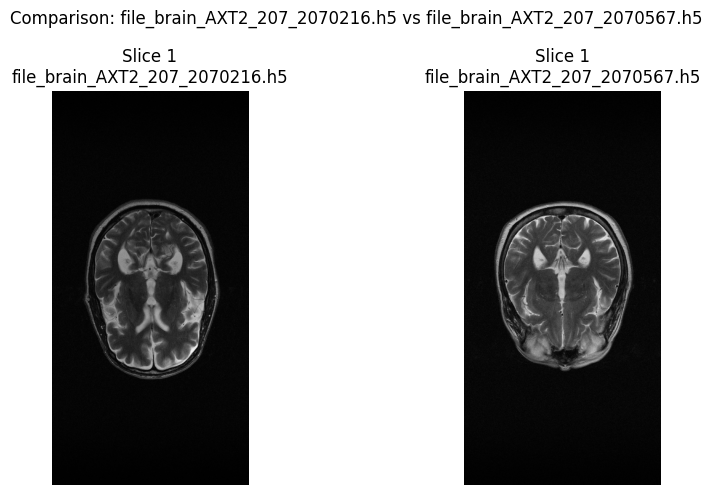

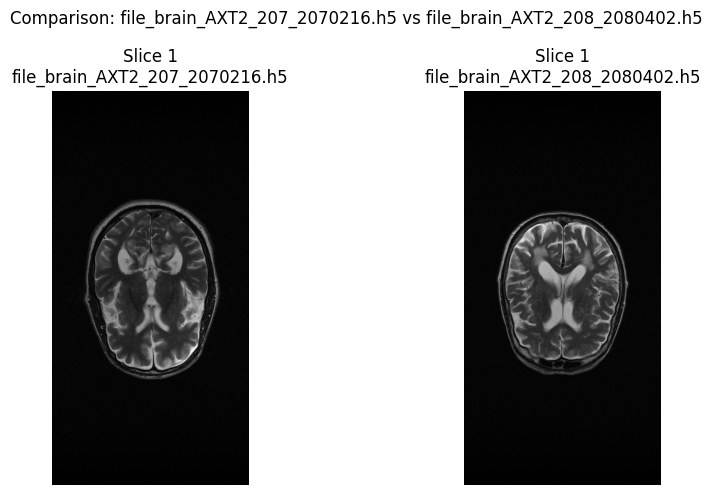

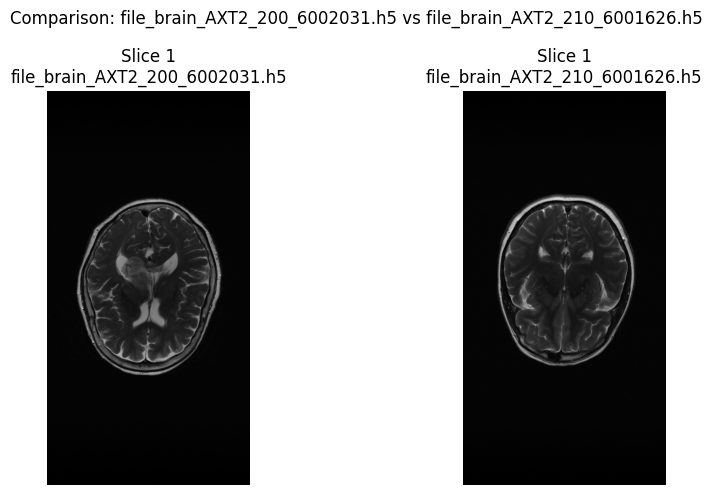

In [ ]:
# Checking if the files are the same by plotting
import h5py
import numpy as np
import matplotlib.pyplot as plt
import torch
from fastmri import ifft2c, tensor_to_complex_np

folder_path = "/content/drive/MyDrive/MRI/multicoil_test_full"

# List of file pairs to compare
file_pairs = [
    ("file_brain_AXT2_206_2060073.h5", "file_brain_AXT2_202_2020339.h5"),
    ("file_brain_AXT2_207_2070240.h5", "file_brain_AXT2_207_2070575.h5"),
    ("file_brain_AXT2_207_2070216.h5", "file_brain_AXT2_208_2080102.h5"),
    ("file_brain_AXT2_207_2070240.h5", "file_brain_AXT2_208_2080177.h5"),
    ("file_brain_AXT2_202_2020011.h5", "file_brain_AXT2_202_2020356.h5"),
    ("file_brain_AXT2_207_2070216.h5", "file_brain_AXT2_207_2070071.h5"),
    ("file_brain_AXT2_207_2070216.h5", "file_brain_AXT2_207_2070567.h5"),
    ("file_brain_AXT2_207_2070216.h5", "file_brain_AXT2_208_2080402.h5"),
    ("file_brain_AXT2_200_6002031.h5", "file_brain_AXT2_210_6001626.h5"),
]


# Function to convert k-space to image using fastMRI
def kspace_to_image_fastmri(kspace_data):
    """Converts k-space data to an image using fastMRI."""
    
    kspace_complex = np.stack((np.real(kspace_data), np.imag(kspace_data)), axis=-1)
    kspace_tensor = torch.tensor(kspace_complex, dtype=torch.float32)

    image_tensor = ifft2c(kspace_tensor)
    image_np = tensor_to_complex_np(image_tensor)

    
    combined_image = np.sqrt(np.sum(np.abs(image_np) ** 2, axis=0))
    normalized_image = (combined_image - np.min(combined_image)) / (np.max(combined_image) - np.min(combined_image)) * 255.0
    return normalized_image.astype(np.uint8)


for pair in file_pairs:
    file1_path = f"{folder_path}/{pair[0]}"
    file2_path = f"{folder_path}/{pair[1]}"

    with h5py.File(file1_path, "r") as file1, h5py.File(file2_path, "r") as file2:
        kspace1 = file1["kspace"][:]  # Load k-space data for file 1
        kspace2 = file2["kspace"][:]  # Load k-space data for file 2

        # Generate images from k-space (combined coil images for the first slice)
        image1 = kspace_to_image_fastmri(kspace1[0])
        image2 = kspace_to_image_fastmri(kspace2[0])

    
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    axes[0].imshow(image1, cmap="gray")
    axes[0].axis("off")
    axes[0].set_title(f"Slice 1\n{pair[0]}")

    axes[1].imshow(image2, cmap="gray")
    axes[1].axis("off")
    axes[1].set_title(f"Slice 1\n{pair[1]}")

    plt.suptitle(f"Comparison: {pair[0]} vs {pair[1]}")
    plt.tight_layout()
    plt.show()


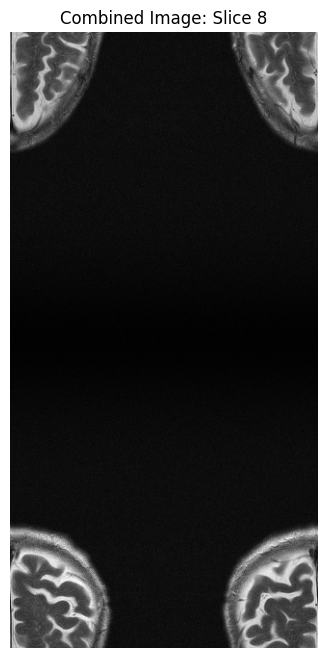

In [ ]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

file_path = "/content/drive/MyDrive/MRI/multicoil_test_full/file_brain_AXT2_206_2060073.h5"  # Replace with the path to your .h5 file


with h5py.File(file_path, "r") as f:
    kspace = f["kspace"][:] 

slice_idx = kspace.shape[0] // 2

combined_image = np.zeros(kspace.shape[2:]) 

for coil_idx in range(kspace.shape[1]):
    kspace_slice_coil = kspace[slice_idx, coil_idx]
    image = np.abs(np.fft.ifft2(np.fft.ifftshift(kspace_slice_coil)))
    combined_image += image

combined_image = (combined_image - np.min(combined_image)) / (np.max(combined_image) - np.min(combined_image)) * 255.0
combined_image = combined_image.astype(np.uint8)

plt.figure(figsize=(8, 8))
plt.imshow(combined_image, cmap="gray")
plt.title(f"Combined Image: Slice {slice_idx}")
plt.axis("off")
plt.show()


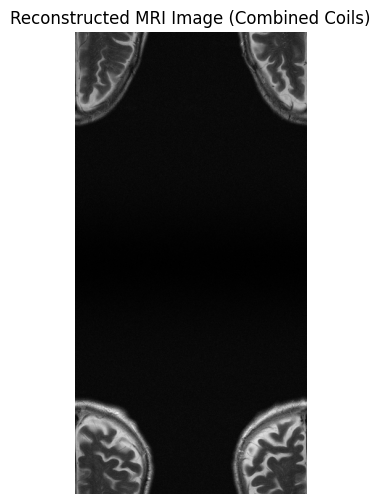

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


# Specify the slice to combine
slice_idx = 7  

kspace_slice = kspace[slice_idx] 

images_coils = np.fft.ifft2(np.fft.ifftshift(kspace_slice, axes=(-1, -2)), axes=(-1, -2))
images_coils = np.abs(images_coils)

combined_image = np.sqrt(np.sum(images_coils ** 2, axis=0))

# Normalize the combined image for better visualization
combined_image = (combined_image - np.min(combined_image)) / (np.max(combined_image) - np.min(combined_image)) * 255.0
combined_image = combined_image.astype(np.uint8)

plt.figure(figsize=(6, 6))
plt.imshow(combined_image, cmap="gray")
plt.title("Reconstructed MRI Image (Combined Coils)")
plt.axis("off")
plt.show()

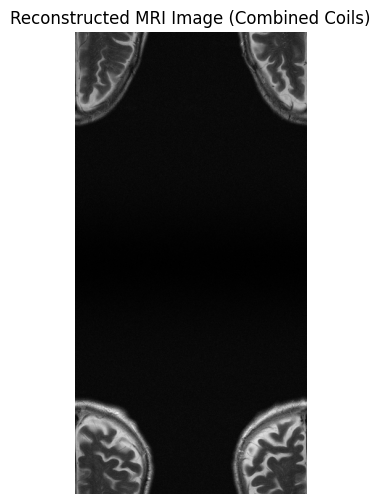

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

slice_idx = 7  


kspace_slice = kspace[slice_idx]  

images_coils = np.fft.ifft2(np.fft.ifftshift(kspace_slice, axes=(-1, -2)), axes=(-1, -2))
images_coils = np.abs(images_coils)


combined_image = np.sqrt(np.sum(images_coils ** 2, axis=0))

# Normalize the combined image for better visualization
combined_image = (combined_image - np.min(combined_image)) / (np.max(combined_image) - np.min(combined_image)) * 255.0
combined_image = combined_image.astype(np.uint8)


plt.figure(figsize=(6, 6))
plt.imshow(combined_image, cmap="gray")
plt.title("Reconstructed MRI Image (Combined Coils)")
plt.axis("off")
plt.show()


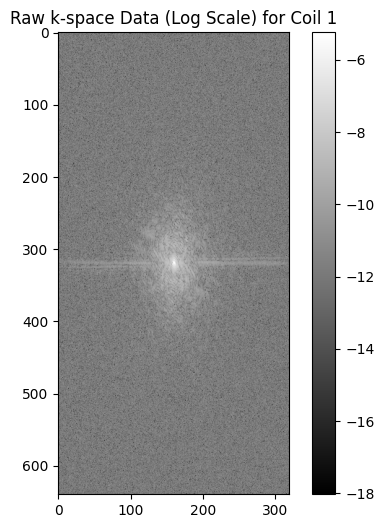

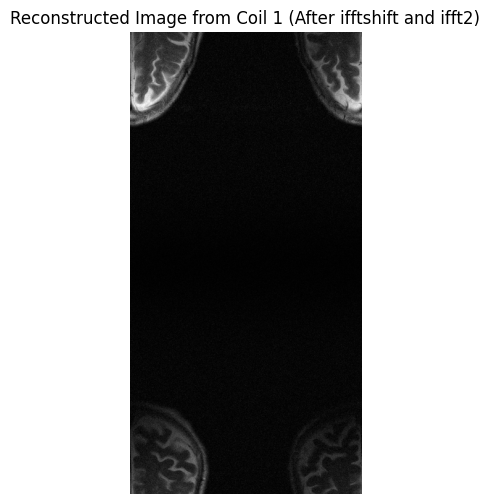

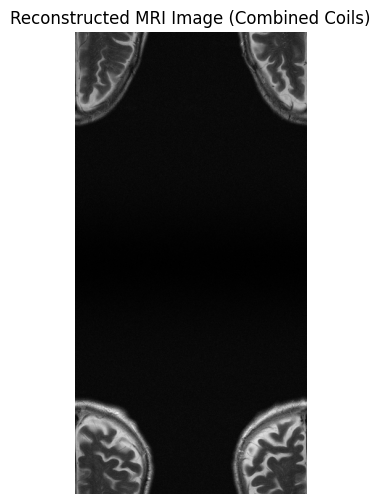

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


slice_idx = 7  # Example slice index

# Extract k-space data for the specific slice
kspace_slice = kspace[slice_idx] 

plt.figure(figsize=(6, 6))
plt.imshow(np.log(np.abs(kspace_slice[0]) + 1e-9), cmap="gray")
plt.title("Raw k-space Data (Log Scale) for Coil 1")
plt.colorbar()
plt.show()

# Apply ifftshift to center k-space for all coils
kspace_shifted = np.fft.ifftshift(kspace_slice, axes=(-1, -2))


images_coils = np.fft.ifft2(kspace_shifted, axes=(-1, -2))
images_coils = np.abs(images_coils)

###########

plt.figure(figsize=(6, 6))
plt.imshow(images_coils[0], cmap="gray")
plt.title("Reconstructed Image from Coil 1 (After ifftshift and ifft2)")
plt.axis("off")
plt.show()


combined_image = np.sqrt(np.sum(images_coils ** 2, axis=0))

combined_image = (combined_image - np.min(combined_image)) / (np.max(combined_image) - np.min(combined_image)) * 255.0
combined_image = combined_image.astype(np.uint8)

# Plot the final combined image
plt.figure(figsize=(6, 6))
plt.imshow(combined_image, cmap="gray")
plt.title("Reconstructed MRI Image (Combined Coils)")
plt.axis("off")
plt.show()


In [ ]:
print(kspace.shape)

(16, 16, 640, 320)


In [ ]:
# changing the files names to have it structured
import os

directory = "/content/drive/MyDrive/MRI/multicoil_test_full"

files = [f for f in os.listdir(directory) if f.endswith(".h5")]

files.sort()

for index, file in enumerate(files, start = 1):

  new_name = f"MRI_{index:03}.h5"

  old_path = os.path.join(directory, file)
  new_path = os.path.join(directory, new_name)

  os.rename(old_path, new_path)
  print(f"Renamed: {file} -> {new_name}")

print("Renaming complete!")

Renamed: file_brain_AXFLAIR_200_6002451.h5 -> MRI_001.h5
Renamed: file_brain_AXFLAIR_200_6002497.h5 -> MRI_002.h5
Renamed: file_brain_AXFLAIR_200_6002564.h5 -> MRI_003.h5
Renamed: file_brain_AXFLAIR_201_6002884.h5 -> MRI_004.h5
Renamed: file_brain_AXFLAIR_201_6002891.h5 -> MRI_005.h5
Renamed: file_brain_AXFLAIR_201_6002921.h5 -> MRI_006.h5
Renamed: file_brain_AXFLAIR_202_6000415.h5 -> MRI_007.h5
Renamed: file_brain_AXFLAIR_202_6000560.h5 -> MRI_008.h5
Renamed: file_brain_AXFLAIR_203_6000903.h5 -> MRI_009.h5
Renamed: file_brain_AXFLAIR_206_6000226.h5 -> MRI_010.h5
Renamed: file_brain_AXFLAIR_206_6000258.h5 -> MRI_011.h5
Renamed: file_brain_AXFLAIR_209_6001383.h5 -> MRI_012.h5
Renamed: file_brain_AXFLAIR_210_6001507.h5 -> MRI_013.h5
Renamed: file_brain_AXFLAIR_210_6001523.h5 -> MRI_014.h5
Renamed: file_brain_AXFLAIR_210_6001916.h5 -> MRI_015.h5
Renamed: file_brain_AXFLAIR_210_6001946.h5 -> MRI_016.h5
Renamed: file_brain_AXT1POST_200_6002126.h5 -> MRI_017.h5
Renamed: file_brain_AXT1POST_2

In [ ]:
!pip install fastmri

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.4/101.4 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 31.2 MB/s eta 0:00:00
  Created wheel for runstats: filename=runstats-2.0.0-py3-none-any.whl size=12358 sha256=327e0ea2600096adcf955e30e8c84a6a314cbdd70cae5fe467068ea419d0e523
  Stored in directory: /root/.cache/pip/wheels/ab/f0/e7/de0153d4ef82770beff902f778ab825fa24c3534cb63564197
Successfully built runstats


In [ ]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import torch

In [ ]:
from fastmri import tensor_to_complex_np, ifft2c
from fastmri.data.transforms import center_crop

In [ ]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

k-space shape: (16, 20, 640, 320)
New k-space shape with complex dim: (16, 20, 640, 320, 2)
Image shape: (16, 20, 640, 320)


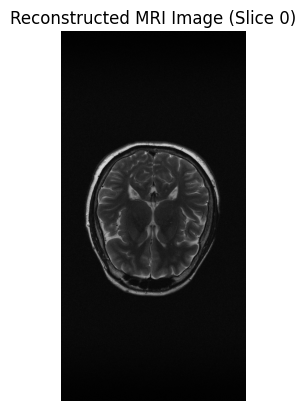

In [ ]:
# Load the file
file_path = "/content/drive/MyDrive/MRI/multicoil_test_full/file_brain_AXT2_206_6000210.h5"

with h5py.File(file_path, "r") as hf:
    kspace = hf["kspace"][:]  
    print(f"k-space shape: {kspace.shape}")

kspace_complex = np.stack((np.real(kspace), np.imag(kspace)), axis=-1) 
print(f"New k-space shape with complex dim: {kspace_complex.shape}") 


kspace_tensor = torch.tensor(kspace_complex, dtype=torch.float32)

# Apply inverse FFT to convert k-space to image domain
image_tensor = ifft2c(kspace_tensor) 
image_np = tensor_to_complex_np(image_tensor) 
print(f"Image shape: {image_np.shape}")  # Shape is -> (16, 16, 640, 320)

slice_idx = 0 
combined_image = np.sqrt(np.sum(np.abs(image_np[slice_idx]) ** 2, axis=0))  

# Plot the combined image
plt.imshow(combined_image, cmap="gray")
plt.title(f"Reconstructed MRI Image (Slice {slice_idx})")
plt.axis("off")
plt.show()

In [ ]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt


from google.colab import drive
drive.mount('/content/drive')


h5_files_path = '/content/drive/MyDrive/MRI_h5_files'
output_path = '/content/drive/MyDrive/MRI_images'  


os.makedirs(output_path, exist_ok=True)
h5_files = [f for f in os.listdir(h5_files_path) if f.endswith('.h5')]


def process_h5_file(h5_file, output_dir):
    with h5py.File(h5_file, 'r') as file:
        kspace = file['kspace'][:]  

        
        num_slices, num_coils, _, _ = kspace.shape
        for slice_idx in range(num_slices):
            for coil_idx in range(num_coils):
                
                kspace_slice_coil = kspace[slice_idx, coil_idx]
                image = np.abs(np.fft.ifft2(np.fft.ifftshift(kspace_slice_coil)))

                # Normalize for better visualization
                image = (image - np.min(image)) / (np.max(image) - np.min(image)) * 255.0
                image = image.astype(np.uint8)

                
                filename = f"MRI_{os.path.basename(h5_file).split('.')[0]}_S{slice_idx}_C{coil_idx}.png"
                output_folder = os.path.join(output_dir, f"MRI_{os.path.basename(h5_file).split('.')[0]}")
                os.makedirs(output_folder, exist_ok=True)
                plt.imsave(os.path.join(output_folder, filename), image, cmap='gray')

# Process each .h5 file
for h5_file in h5_files:
    process_h5_file(os.path.join(h5_files_path, h5_file), output_path)

print("Processing complete. Check your Google Drive for saved images.")


In [ ]:
# masking each image before inputting into the network Will be done in the processing stage